In [119]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

In [ ]:
# Scelta modelli
model_a = {'stable_diffusion'}
model_b = {'taming_transformer'}

In [ ]:
class ImageFolder(Dataset):

    def __init__(self, root_dir, model_a, model_b, metadata_name='metadata.csv', nrows=None, transform=None, random_state=42):
        self.root_dir = Path(root_dir)
        self.metadata_name = metadata_name
        self.transform = transform
        self.random_state = random_state

        # Carica campioni etichettati 0 e 1
        samples_a = self._load_samples(model_a, label=0, nrows=nrows)
        samples_b = self._load_samples(model_b, label=1, nrows=nrows)

        print(f"Caricate immagini: '{model_a}': {len(samples_a)} — '{model_b}': {len(samples_b)}")
        if len(samples_a) == 0 or len(samples_b) == 0:
            raise ValueError(f"Dataset non valido: una delle due classi ha 0 immagini.")

        # Bilancia le classi
        self.samples = self._balance_binary(samples_a + samples_b)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(self.root_dir / img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def _load_samples(self, folder, label, nrows=None):
        folder_path = self.root_dir / folder
        meta_file = folder_path / self.metadata_name

        if not meta_file.exists():
            print(f"Metadata file not found for folder: {folder}")
            return []

        df = pd.read_csv(meta_file)

        if not {'image_path', 'target'}.issubset(df.columns):
            print(f"Metadata missing required columns in: {meta_file}")
            return []

        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        df = df[df['target'] > 0]  # Solo immagini valide

        if nrows:
            df = df.sample(n=nrows, random_state=self.random_state)  # Campionamento casuale

        samples = [(Path(folder) / row['image_path'], label) for _, row in df.iterrows()]
        return samples

    def _balance_binary(self, samples):
        # Bilanciamento tramite undersampling
        X = np.arange(len(samples)).reshape(-1, 1)
        y = [label for _, label in samples]
        rus = RandomUnderSampler(random_state=self.random_state)
        X_res, y_res = rus.fit_resample(X, y)
        return [samples[i] for i in X_res.ravel()]


In [ ]:
def train_SVM(dataset: pd.DataFrame, val_size=0.1, test_size=0.1):
    # Estrai X e label
    X = dataset.drop(columns='label').values
    y_str = dataset['label'].values

    # Codifica le label
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)

    # Primo split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Secondo split: train vs val
    val_ratio = val_size / (1 - test_size)  # perché X_temp = 1 - test_size
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42
    )

    print(f"Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

    # Parametri da cercare
    svc = SVC(class_weight='balanced')
    param_grid = [
        {'kernel': ['linear'],  'C': [0.1, 1, 10]},
        {'kernel': ['rbf'],     'C': [1, 10], 'gamma': ['scale', 0.1]},
        {'kernel': ['sigmoid'], 'C': [1, 10], 'gamma': ['scale', 0.1], 'coef0': [0.0, 0.1, 0.5]}
    ]

    # GridSearch su validation
    grid = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"Best params from validation: {grid.best_params_}")

    # Riaddestra sul train + val usando i migliori iperparametri
    best_svm = SVC(**grid.best_params_, class_weight='balanced')
    best_svm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

    # Test finale
    prediction = best_svm.predict(X_test)

    y_test_labels = label_encoder.inverse_transform(y_test)
    pred_labels = label_encoder.inverse_transform(prediction)

    # Report
    accuracy = accuracy_score(y_test_labels, pred_labels)
    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(y_test_labels, pred_labels)}")
    cf = confusion_matrix(y_test_labels, pred_labels)
    print(f"Confusion Matrix:\n{cf}")
    plot_confusion_matrix(cf, class_labels=["Stable Diffusion", "Taming Transformer"])

def plot_confusion_matrix(cf, class_labels):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Prepara etichette per celle: conteggio e percentuale
    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    labels = [f"{count}\n({percent})" for count, percent in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cf.shape)

    # Imposta il grafico
    plt.figure(figsize=(7, 6))
    sns.set(style="whitegrid")

    ax = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', cbar=False,
                     xticklabels=class_labels, yticklabels=class_labels)

    # Titoli e assi
    ax.set_title("Matrice di Confusione")
    ax.set_xlabel("Classe Predetta")
    ax.set_ylabel("Classe Reale")

    ax.xaxis.set_ticklabels(class_labels, rotation=20)
    ax.yaxis.set_ticklabels(class_labels, rotation=0)

    plt.tight_layout()
    plt.show()


✅ Caricate immagini: 'stable_diffusion': 500 — 'taming_transformer': 500


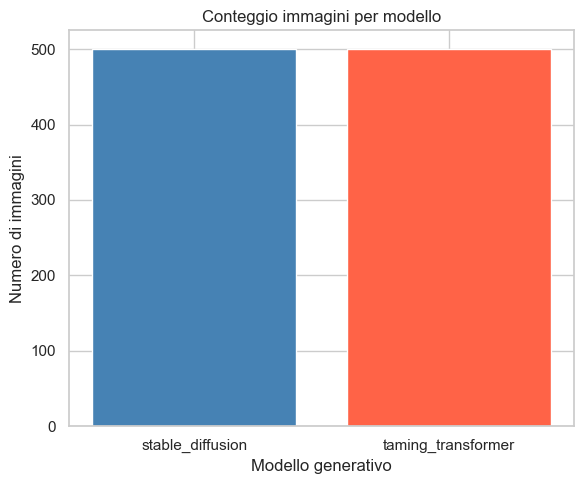

In [123]:
# Trasformazioni standard del modello ViT-B/16
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

# Caricamento del dataset con label numeriche e trasformazioni
dataset = ImageFolder(
    root_dir='./archive',
    model_a="stable_diffusion",
    model_b="taming_transformer",
    nrows=500, 
    transform=transform
)

# DataLoader per batch processing
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Conversione dei sample in DataFrame
data = pd.DataFrame(dataset.samples, columns=['path', 'label'])

# Mapping esplicito per rendere leggibili le etichette numeriche
label_map = {0: 'stable_diffusion', 1: 'taming_transformer'}
data['label_name'] = data['label'].map(label_map)

# Conteggio delle classi
counts = data['label_name'].value_counts().loc[['stable_diffusion', 'taming_transformer']]

# Disegna il plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(counts.index, counts.values, color=['steelblue', 'tomato'])
ax.set_title("Conteggio immagini per modello")
ax.set_xlabel("Modello generativo")
ax.set_ylabel("Numero di immagini")
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Estrazione delle features

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carica il modello ViT-B/16 pre-addestrato
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# Rimuove la testa di classificazione
model.heads.head = nn.Identity()
model.eval().to(device)

all_feats = []
all_labels = []

# Estrazione feature senza gradienti
with torch.no_grad():
    for imgs, labs in tqdm(loader, desc="Estrazione delle feature"):
        imgs = imgs.to(device)
        feats = model(imgs)
        all_feats.append(feats.cpu().numpy())
        all_labels.extend(labs.numpy())

# Unione di tutte le feature in un'unica matrice
features = np.vstack(all_feats)
labels = np.array(all_labels)

# Creazione DataFrame finale
feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df = pd.DataFrame(features, columns=feat_cols)
df['label'] = labels

# Salva il DataFrame completo con tutte le feature originali per le operazioni successive come la PCA
feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df_full = pd.DataFrame(features, columns=feat_cols)
df_full['label'] = labels

# Debug: visualizza numero di esempi per classe
print(df.groupby('label').size())

Estrazione delle feature: 100%|██████████| 32/32 [03:42<00:00,  6.95s/it]

label
0    500
1    500
dtype: int64


In [125]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,label
0,-0.166774,-1.072634,-0.099808,0.067912,0.435229,1.278587,-0.153517,0.429770,-1.030993,0.318487,...,0.069857,-0.636492,-0.525591,-0.440032,-0.062515,0.072905,-1.225682,-0.436871,-1.175305,0
1,0.217288,0.188374,-0.348553,0.103571,0.091890,0.523275,-0.371245,-0.465541,0.311227,-0.486335,...,-0.571954,-1.283350,0.118887,-0.232231,0.514003,-0.849035,0.148398,-0.041164,0.424304,0
2,-1.890382,-0.703413,0.069456,-1.071082,0.004553,0.369737,0.247775,0.525876,0.416423,0.337115,...,0.378480,-1.800678,-0.097180,-0.190378,-1.721508,-0.752026,0.377846,0.758224,-0.153907,0
3,-1.683022,-0.675271,0.296713,-0.450559,0.237623,0.101747,-0.242081,0.272931,0.627889,-0.232580,...,0.181882,-1.147005,-0.034096,0.336099,0.127406,-0.088925,0.856983,-0.271893,-0.465289,0
4,-1.008344,0.383236,0.016593,0.890300,-0.049289,0.267488,0.452216,0.520227,0.580516,-0.230229,...,-0.514886,-0.091198,0.089711,0.555823,0.030694,0.547864,1.571421,0.547818,0.247722,0


### Training

🔍 Split: Train=800, Val=100, Test=100
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.9300
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        50
           1       0.92      0.94      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Confusion Matrix:
[[46  4]
 [ 3 47]]


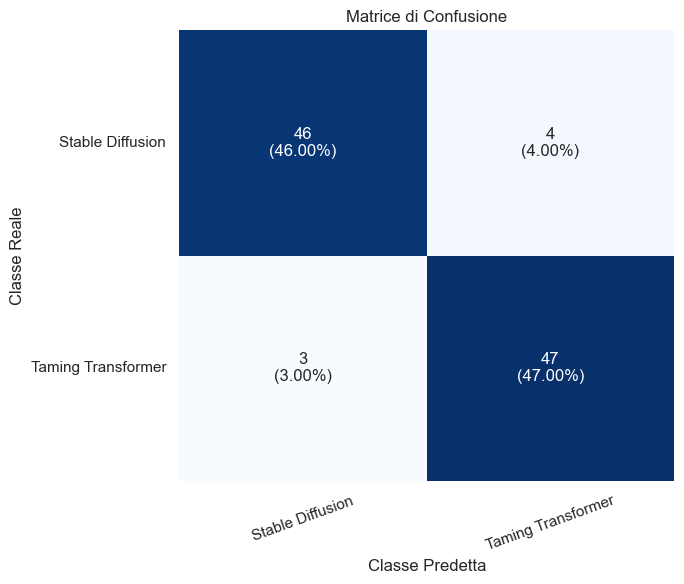

In [126]:
train_SVM(df)

🔍 Split: Train=599, Val=101, Test=300
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.9133
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       150
           1       0.93      0.89      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

Confusion Matrix:
[[140  10]
 [ 16 134]]


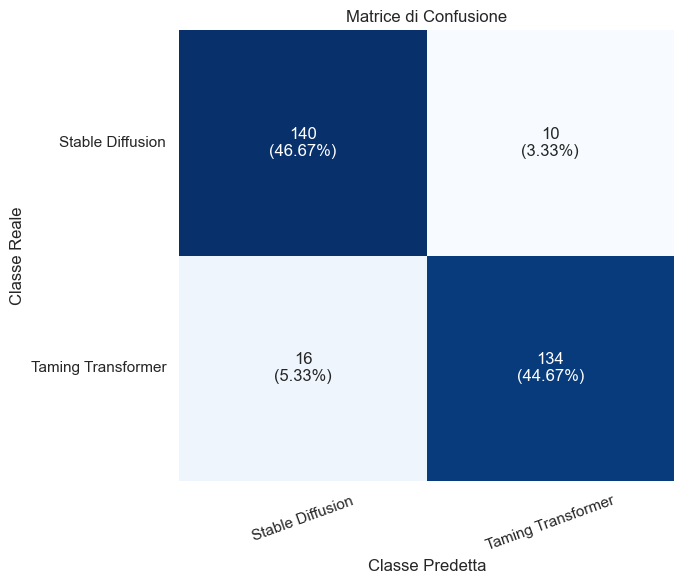

In [127]:
train_SVM(df, test_size=0.3)

🔍 Split: Train=700, Val=100, Test=200
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.9100
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       100
           1       0.92      0.90      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

Confusion Matrix:
[[92  8]
 [10 90]]


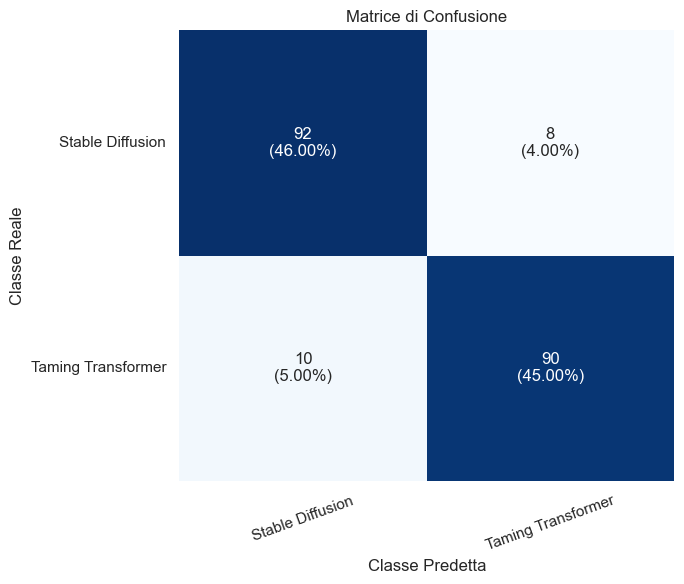

In [128]:
train_SVM(df, test_size=0.2)

# Riduzione del numero delle features (PCA)

In [129]:
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)
print(f"Shape dopo PCA: {features_pca.shape}")

Shape dopo PCA: (1000, 3)


In [130]:
df = pd.DataFrame(features_pca, columns=['PC1', 'PC2', 'PC3'])
df['label'] = labels

fig = px.scatter_3d(
    df, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA 3D Visualization',
    opacity=0.7
)
fig.show()


In [131]:
# Seleziona solo le colonne delle feature
feat_cols = [c for c in df_full.columns if c.startswith('feat_')]
X = df_full[feat_cols].values

# Fit completo della PCA per analizzare la varianza cumulativa
pca_full = PCA().fit(X)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Determina quante componenti servono per spiegare almeno il 95% della varianza
n_components = np.argmax(cumvar >= 0.95) + 1
print(f"Numero di componenti per spiegare il 95% della varianza: {n_components}")

# Riduzione dimensionale con il numero ottimale di componenti
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Crea DataFrame con le componenti ridotte
pca_cols = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df_full.index)

# Aggiungi le label
df_reduced = pd.concat([df_full[['label']], df_pca], axis=1)

# Visualizza info
print("Shape originale:", df_full.shape)
print("Shape ridotto:", df_reduced.shape)
df_reduced.head()

Numero di componenti per spiegare il 95% della varianza: 395
Shape originale: (1000, 769)
Shape ridotto: (1000, 396)


,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC386,PC387,PC388,PC389,PC390,PC391,PC392,PC393,PC394,PC395
0,0,3.791814,-2.063655,-0.178983,-3.787035,1.649940,-0.500829,2.799037,5.045511,0.661739,...,-0.356183,0.177763,0.259760,-0.746178,-0.232379,0.116574,0.501036,-0.020594,0.403894,0.013318
1,0,3.346736,-0.534075,-0.208345,1.684372,0.041189,0.434519,-1.183700,0.315054,0.412339,...,0.129336,0.218001,-0.357339,-0.031676,-0.047204,0.179557,0.162842,0.051133,-0.384366,0.710672
2,0,-6.480240,-9.802488,-3.688288,-0.235404,-2.742221,1.451887,-1.479141,-0.429289,0.806335,...,0.119089,0.489510,-0.383987,-0.093661,0.418257,-0.076832,-0.266790,0.196047,-0.344380,-0.783084
3,0,-7.426609,-9.203156,-2.717106,-0.507379,-1.125996,0.948399,-0.086825,-0.566863,-1.528303,...,-0.067507,-0.173726,0.181003,-0.392015,-0.032034,0.049761,-0.357258,0.035158,0.110901,0.167879
4,0,3.090650,-0.389498,-1.112874,-3.960106,0.360389,-0.676264,2.688420,0.175051,-1.386168,...,0.630228,0.960895,-1.204116,-0.345556,-0.282094,0.451013,0.143164,-0.501096,0.000991,0.121454


🔍 Split: Train=800, Val=100, Test=100
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        50
           1       0.92      0.92      0.92        50

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

Confusion Matrix:
[[46  4]
 [ 4 46]]


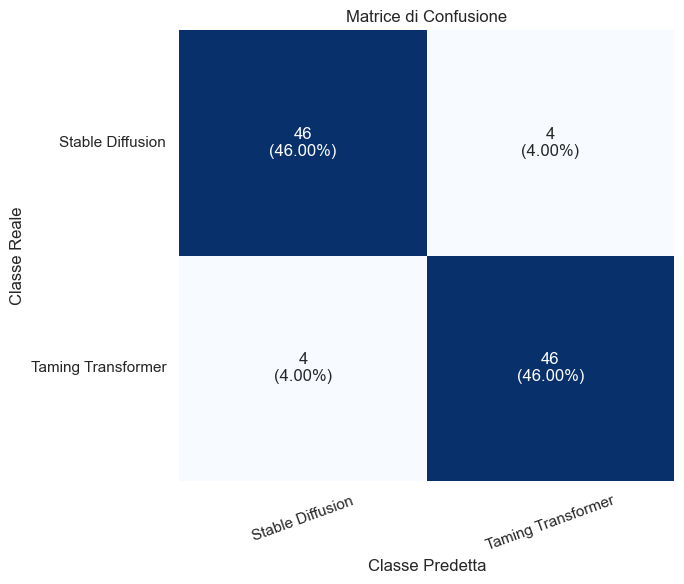

In [132]:
train_SVM(df_reduced)

🔍 Split: Train=599, Val=101, Test=300
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.9100
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       150
           1       0.92      0.89      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

Confusion Matrix:
[[139  11]
 [ 16 134]]


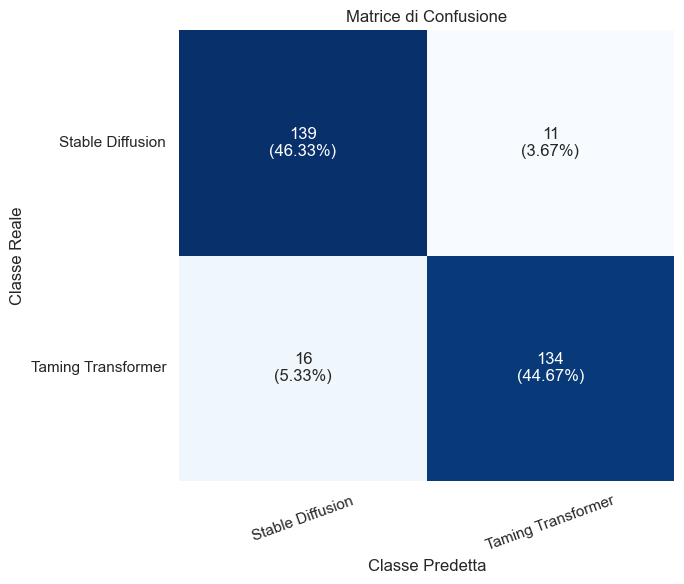

In [133]:
train_SVM(df_reduced, test_size=0.3)

🔍 Split: Train=700, Val=100, Test=200
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       100
           1       0.93      0.91      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

Confusion Matrix:
[[93  7]
 [ 9 91]]


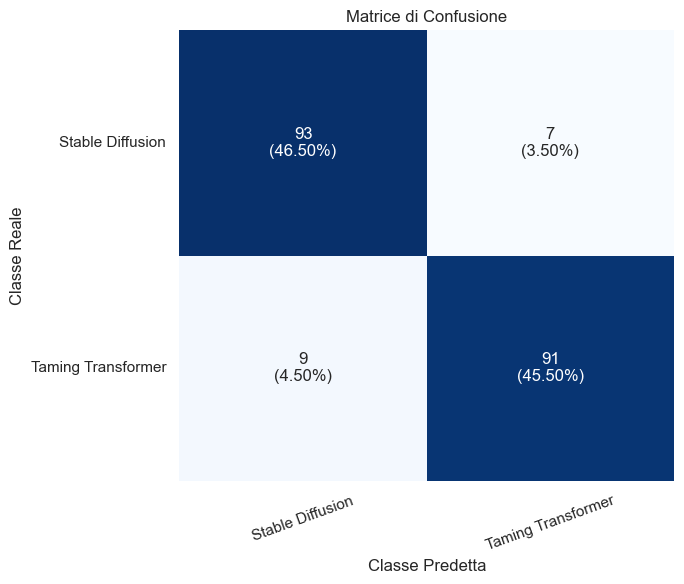

In [134]:
train_SVM(df_reduced, test_size=0.2)